# Finding Donors for CharityML

In this project I'm going to employ several supervised algorithms to accurately model individual's income using data collected from the 1994 U.S. Census. Then I'm going to choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. The goal is to construct a model that accurately predicts whether and individual makes more than $50,000. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income).

## Explore the Data

The last column in the dataset,`'income'`, is the target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [21]:
# import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import seaborn as sn
from IPython.display import display

# import supplementary visualization code visuals.py
import visuals as vs

# display for notebooks
%matplotlib inline

# load the Census dataset
data = pd.read_csv('census.csv')

# display first row
display(data.head(1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [16]:
# total number of records
n_records = data.shape[0]

# number of records where individual's income is more than $50,000
n_greater_50k = data.query('income == ">50K"').shape[0]

# number of records where individual's income is at most $50,000
n_at_most_50k = data.query('income == "<=50K"').shape[0]

# percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k/n_records)*100

# print results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


The dataset is unbalanced. There're less records where individuals make more than $50,000.

**Feature Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

/Users/dmitrykrasnikov/anaconda3/envs/ds/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


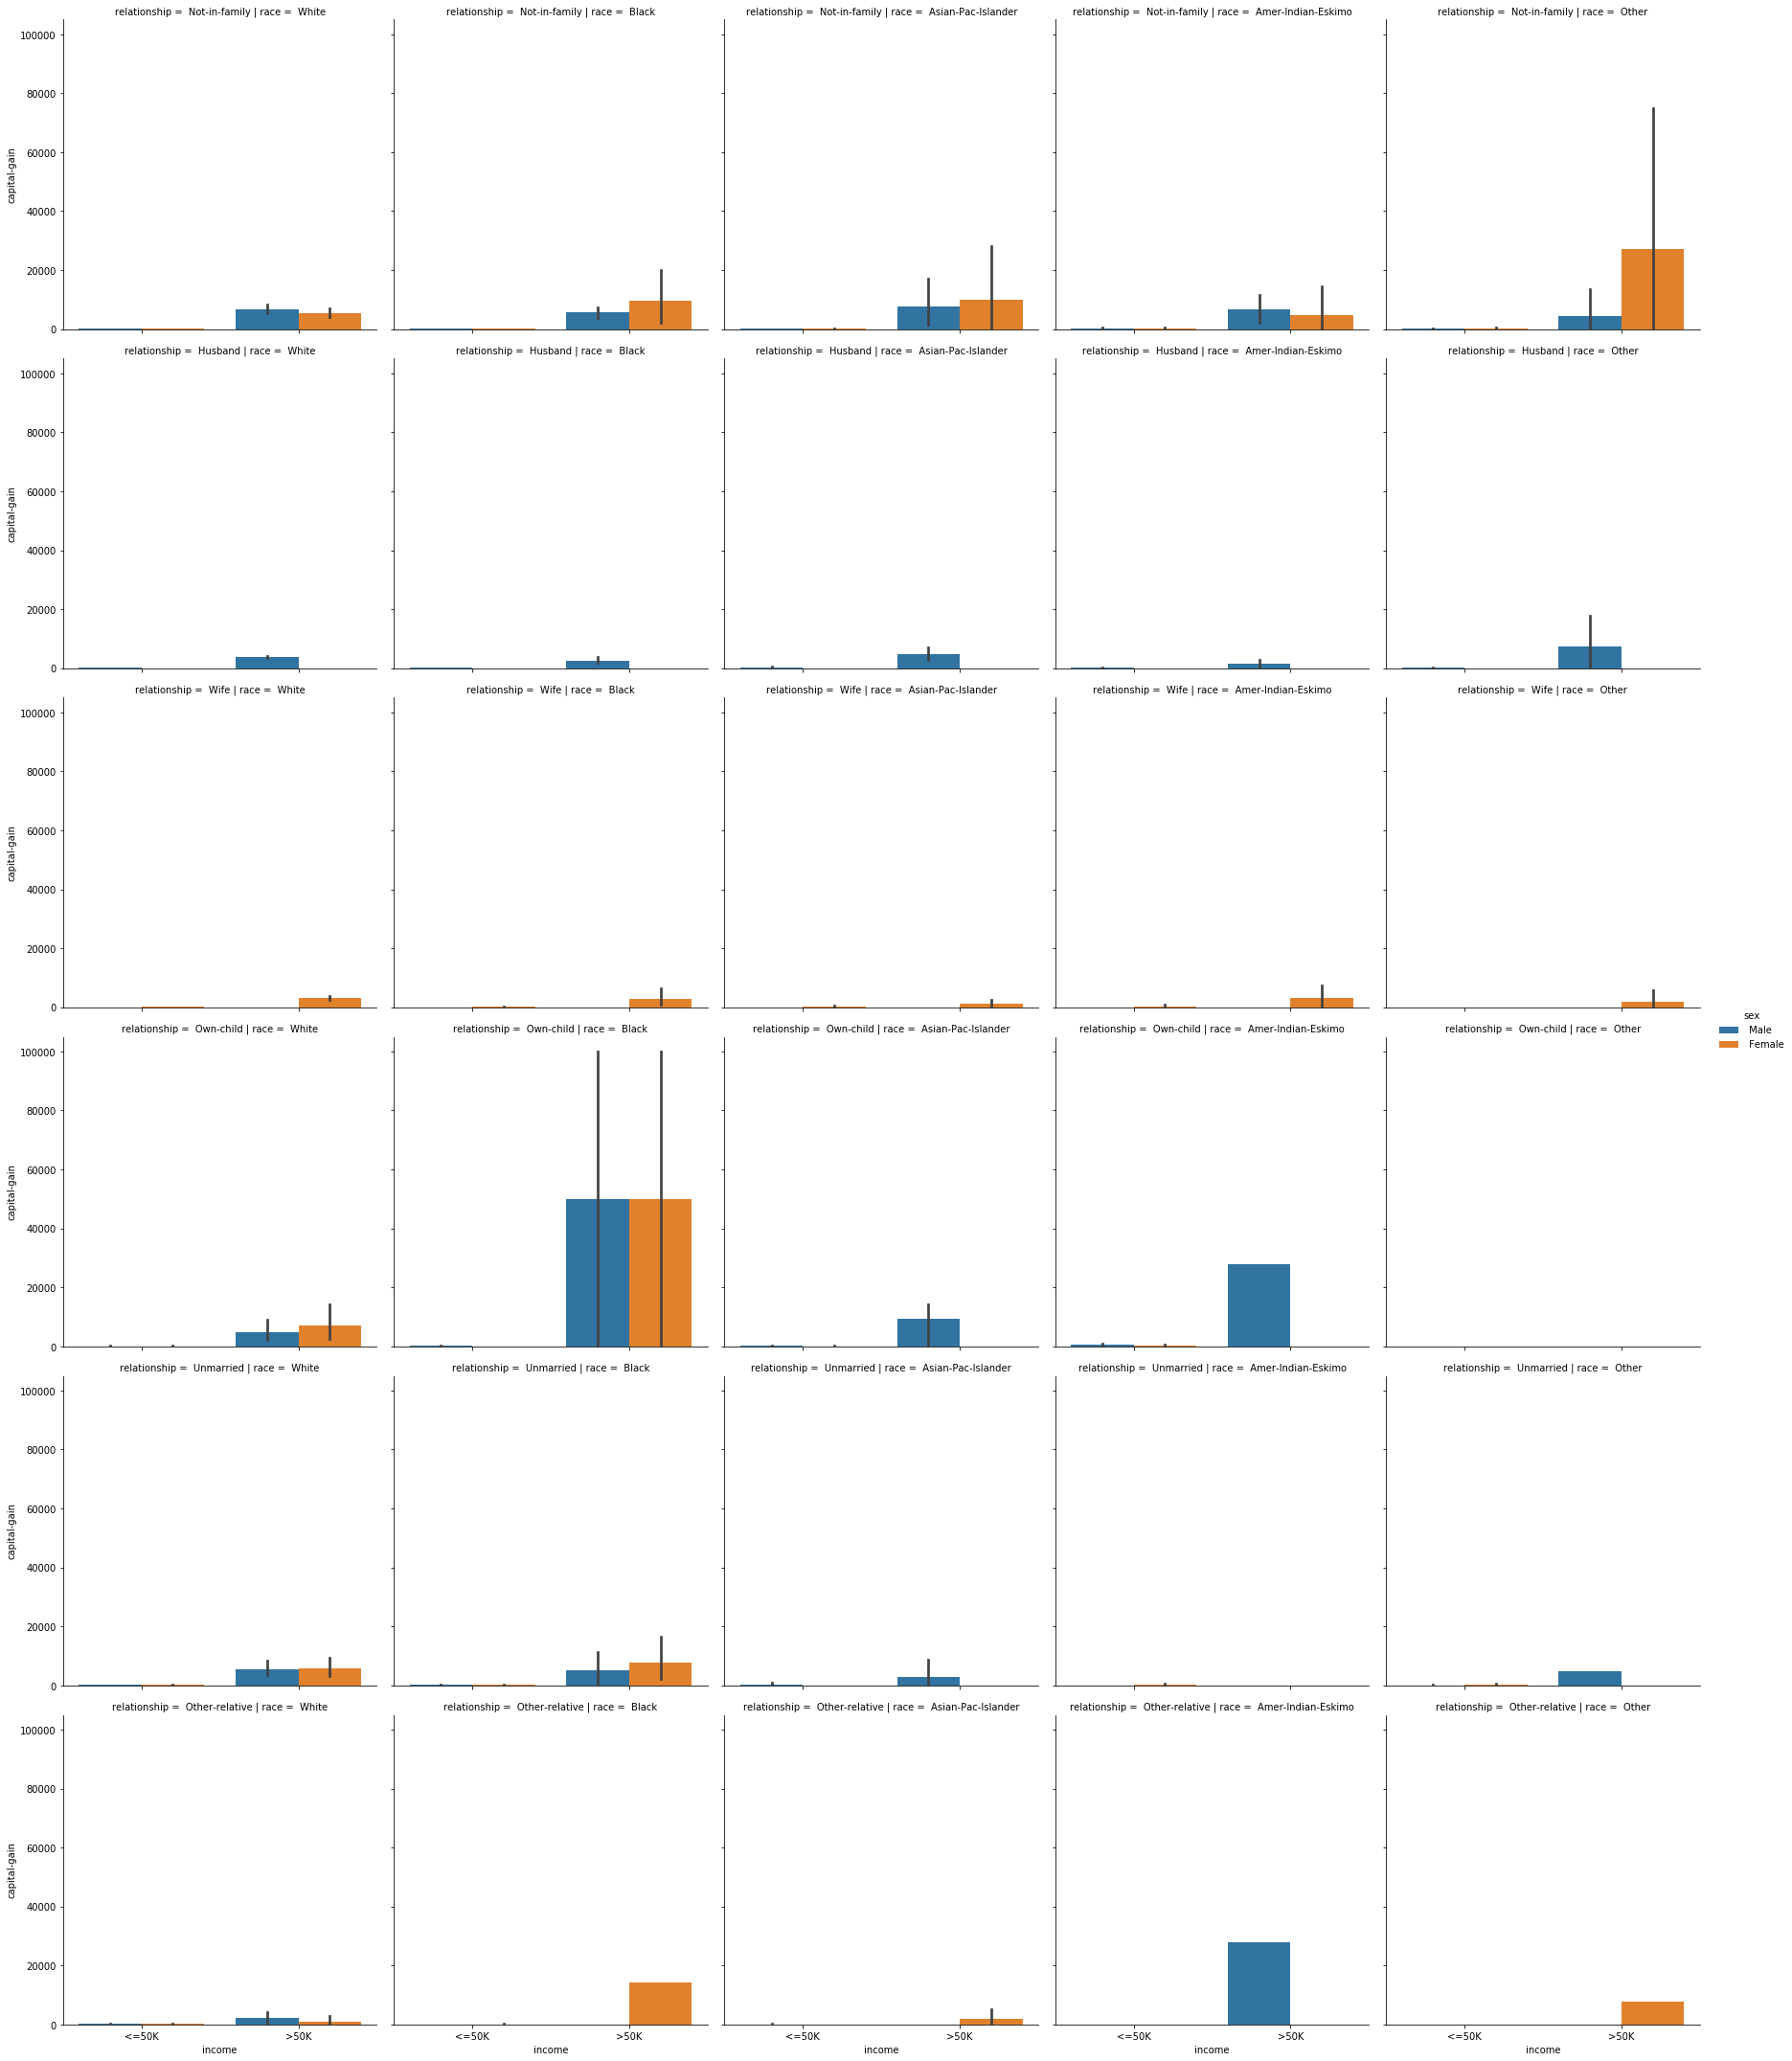

In [17]:
# visualize features of the data
sn.catplot('income', 'capital-gain', hue='sex', data = data,
              kind='bar', col='race', row='relationship',
              legend=True);

## Prepare the Data

In this part, I'm going to preprocess the data. Fortunately, for this dataset, there're no invalid or missing entries to deal with. However, there're some qualities about certain features that must be adjusted.

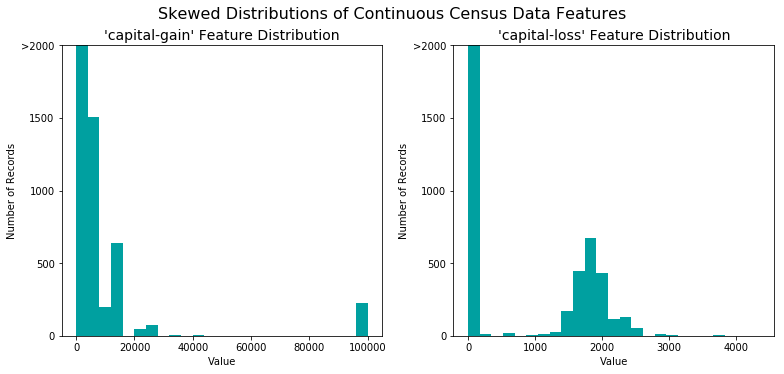

In [18]:
# split data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis=1)

# visualize skewed continuous features of original data
vs.distribution(data)

`'capital-gain'` and `'capital-loss'` are highly skewed features. A logarithmic transformation is going to significantly reduce the range of values. 

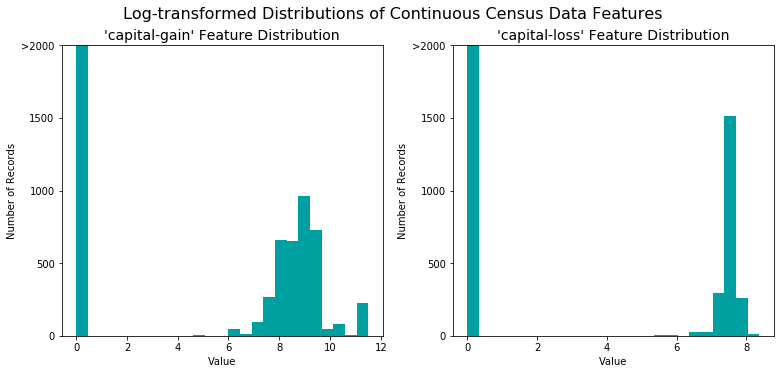

In [19]:
# log-transfrom the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# visualize the new log distributions
vs.distribution(features_log_transformed, transformed=True)

In addition to performing transformations on features that are highly skewed, it's good to perform some type of scaling. This will ensure that each feature is treated equally when applying supervised learners.

In [20]:
# import scaler
from sklearn.preprocessing import MinMaxScaler

# initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transformed = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transformed[numerical] = scaler.fit_transform(features_log_minmax_transformed[numerical])

# show some results of scaling
display(features_log_minmax_transformed.head(5))

/Users/dmitrykrasnikov/anaconda3/envs/ds/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


There're several features for each record that are non-numeric. These categorical features need to be converted using the one-hot encoding scheme.

Additionally, the non-numeric target label `'income'` needs to be converted to numeric values.

In [22]:
# import encoder
from sklearn.preprocessing import LabelEncoder

# one-hot encode features
features_final = pd.get_dummies(features_log_minmax_transformed)

# encode target label to numerical values
le = LabelEncoder()
income = le.fit_transform(income_raw)

# print number of features after one-hot encoding
encoded = list(features_final.columns)
print('{} total features after one-hot encoding'.format(len(encoded)))

# see encoded features
# print(encoded)

103 total features after one-hot encoding


Now I'm going to split data into training and test sets. 80% of data for training and 20% for testing.

In [23]:
# import splitter
from sklearn.model_selection import train_test_split

# split features and target into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, income,
                                                    test_size = 0.2,
                                                    random_state = 1)
# show results of the split
print('Testing set has {} samples'.format(X_train.shape[0]))
print('Testing set has {} samples'.format(X_test.shape[0]))

Testing set has 36177 samples
Testing set has 9045 samples
